In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
# Extract Files from Zip file
from zipfile import ZipFile
read_file='/content/drive/My Drive/cell-images-for-detecting-malaria.zip'
with ZipFile(read_file,'r') as f:
  f.extractall()
  print('Done')

Done


In [3]:
! ls


cell_images  drive  sample_data


In [4]:
# Import Required libraries
import glob
import numpy as np
from keras.preprocessing.image import ImageDataGenerator,img_to_array,array_to_img,load_img
from keras.models import Sequential
from keras.layers import Dense,Conv2D,MaxPooling2D,Flatten,Dropout
from keras.optimizers import Optimizer
import keras
import matplotlib.pyplot as plt
from keras.applications.vgg16 import VGG16
from keras.models import Model,Input
import keras
from keras.applications.vgg16 import preprocess_input
from keras.callbacks import ModelCheckpoint, EarlyStopping



Using TensorFlow backend.


In [0]:
# load Infected Data and Uninfected Data

infected_data=glob.glob('/content/cell_images/Parasitized/*')

uninfected_data=glob.glob('/content/cell_images/Uninfected/*')


In [6]:
len(infected_data),len(uninfected_data)

13780

In [9]:
infected_data[:5]

['/content/cell_images/Parasitized/C132P93ThinF_IMG_20151004_152642_cell_7.png',
 '/content/cell_images/Parasitized/C180P141NThinF_IMG_20151201_164714_cell_184.png',
 '/content/cell_images/Parasitized/C180P141NThinF_IMG_20151201_164714_cell_186.png',
 '/content/cell_images/Parasitized/C184P145ThinF_IMG_20151203_104334_cell_54.png',
 '/content/cell_images/Parasitized/C146P107ThinF_IMG_20151018_134554_cell_247.png']

In [10]:
uninfected_data[:5]

['/content/cell_images/Uninfected/C37BP2_thinF_IMG_20150620_131423a_cell_63.png',
 '/content/cell_images/Uninfected/C155P116ThinF_IMG_20151115_143125_cell_42.png',
 '/content/cell_images/Uninfected/C219ThinF_IMG_20151106_150314_cell_169.png',
 '/content/cell_images/Uninfected/C226ThinF_IMG_20151112_131546_cell_172.png',
 '/content/cell_images/Uninfected/C160P121ThinF_IMG_20151116_093629_cell_13.png']

In [0]:
# we have Images but how can we predict it without Labels
# we should create labels for recognise wheather the cell is infected or not
# lets create bianry category (1 for infected and 0 for uninfected)

In [0]:
# labels for Infected Cell
infected_labels=[]
for i in range(len(infected_data)):
  i=1
  infected_labels.append(i)

In [0]:
# do the same for uninfected images
uninfected_labels=[]
for i in range(len(uninfected_data)):
  i=0
  uninfected_labels.append(i)



In [0]:
import pandas as pd
# now we have Images and Labels so lets go for a Concatenating all the data and create a DataFrame 
df_infected_img=pd.Series(infected_data)
df_uninfected_img=pd.Series(uninfected_data)
df_infected_labels=pd.Series(infected_labels)
df_uninfected_labels=pd.Series(uninfected_labels)


In [0]:
df_imgs=pd.concat([df_infected_img,df_uninfected_img])
df_labels=pd.concat([df_infected_labels,df_uninfected_labels])


In [0]:
 df_dataset=pd.concat([df_imgs,df_labels],axis=1)

In [0]:
df_dataset.columns=['Images','labels']

In [0]:
df_dataset.reset_index(drop=True,inplace=True) # Reset index 

In [32]:
#this are the files which was giving error while loading Images so we should Drop it. 
print(df_dataset[df_dataset['Images']=='/content/cell_images/Uninfected/Thumbs.db'])
print(df_dataset[df_dataset['Images']=='/content/cell_images/Parasitized/Thumbs.db'])

                                          Images  labels
20558  /content/cell_images/Uninfected/Thumbs.db       0
                                          Images  labels
6773  /content/cell_images/Parasitized/Thumbs.db       1


In [0]:
df_dataset.drop(20558,axis=0,inplace=True)
df_dataset.drop(6773,axis=0,inplace=True)
df_dataset.reset_index(drop=True,inplace=True)

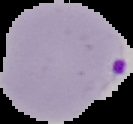

In [34]:
# infected cell looks like this Image
load_img(df_dataset['Images'][137]) 

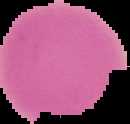

In [57]:
 # uninfected cell looks like this Image
 load_img(df_dataset['Images'][3000])

In [0]:
X=df_dataset.drop('labels',axis=1)
y=df_dataset['labels']

In [0]:
# Divide dataset into training and Validation
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=2)

In [38]:
X_train.shape,y_train.shape,X_test.shape,y_test.shape

((22046, 1), (22046,), (5512, 1), (5512,))

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


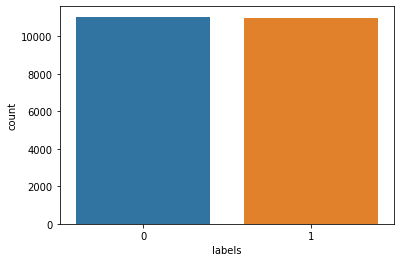

In [58]:
import seaborn as sns
# checking for Balance Dataset
sns.countplot(y_train)

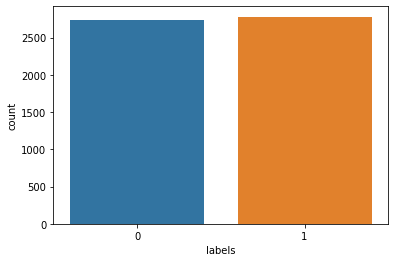

In [59]:
sns.countplot(y_test)

In [0]:
# load image and covert into array
train_imgs=[img_to_array(load_img(img,target_size=(150,150))) for img in X_train['Images']]
train_imgs=np.array(train_imgs)                         

In [0]:
test_imgs=[img_to_array(load_img(img,target_size=(150,150))) for img in X_test['Images']]
test_imgs=np.array(test_imgs)

 Basic CNN model with Data Augmentation

In [0]:

train_datagen=ImageDataGenerator(rescale=1./255.0,horizontal_flip=True,rotation_range=50,fill_mode='nearest',
                                 zoom_range=0.3)
test_datagen=ImageDataGenerator(rescale=1./255.0)

In [43]:
train_generator=train_datagen.flow(train_imgs,y_train,batch_size=30)
test_generator=test_datagen.flow(test_imgs,y_test,batch_size=20)


input_shape=(150,150,3)
model=Sequential()
model.add(Conv2D(64,kernel_size=(3,3),input_shape=input_shape,activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(128,kernel_size=(3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(228,kernel_size=(3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(512,activation='relu'))
model.add(Dense(128,activation='relu'))

model.add(Dense(1,activation='sigmoid'))

model.compile(optimizer=keras.optimizers.RMSprop(),loss='binary_crossentropy',metrics=['accuracy'])

history=model.fit_generator(train_generator,validation_data=test_generator,epochs=50,steps_per_epoch=50)

Epoch 1/50
50/50 [==============================] - 22s 439ms/step - loss: 1.3301 - accuracy: 0.5107 - val_loss: 0.6898 - val_accuracy: 0.5778
Epoch 2/50
50/50 [==============================] - 14s 286ms/step - loss: 0.7021 - accuracy: 0.5207 - val_loss: 0.6852 - val_accuracy: 0.6421
Epoch 3/50
50/50 [==============================] - 14s 289ms/step - loss: 0.6916 - accuracy: 0.5827 - val_loss: 0.5210 - val_accuracy: 0.5374
Epoch 4/50
50/50 [==============================] - 14s 288ms/step - loss: 0.7326 - accuracy: 0.6647 - val_loss: 0.4555 - val_accuracy: 0.7442
Epoch 5/50
50/50 [==============================] - 14s 288ms/step - loss: 0.4411 - accuracy: 0.8407 - val_loss: 0.7763 - val_accuracy: 0.7859
Epoch 6/50
50/50 [==============================] - 14s 289ms/step - loss: 0.3941 - accuracy: 0.8647 - val_loss: 0.0692 - val_accuracy: 0.9265
Epoch 7/50
50/50 [==============================] - 14s 286ms/step - loss: 0.3368 - accuracy: 0.8840 - val_loss: 0.2906 - val_accuracy: 0.9296

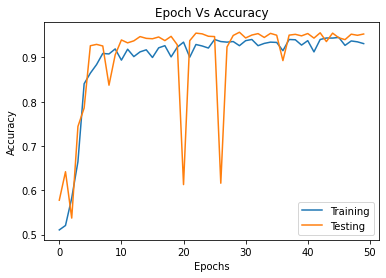

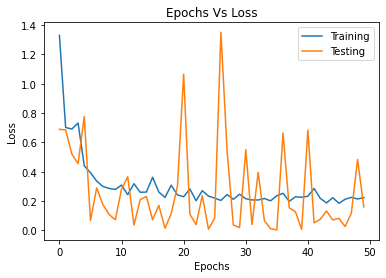

In [44]:

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['Training','Testing'],loc='best')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Epoch Vs Accuracy')
plt.show()


plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Training','Testing'],loc='best')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Epochs Vs Loss')
plt.show()

In [0]:
# we can see there is spiked in validation Data because of overfitting lets apply Dropout Regularization

In [46]:
train_generator=train_datagen.flow(train_imgs,y_train,batch_size=30)
test_generator=test_datagen.flow(test_imgs,y_test,batch_size=20)


input_shape=(150,150,3)
model=Sequential()
model.add(Conv2D(64,kernel_size=(3,3),input_shape=input_shape,activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(128,kernel_size=(3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(228,kernel_size=(3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(512,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.4))

model.add(Dense(1,activation='sigmoid'))

model.compile(optimizer=keras.optimizers.RMSprop(),loss='binary_crossentropy',metrics=['accuracy'])

history=model.fit_generator(train_generator,validation_data=test_generator,epochs=30,steps_per_epoch=50)

Epoch 1/30
50/50 [==============================] - 16s 320ms/step - loss: 0.8903 - accuracy: 0.5107 - val_loss: 0.6928 - val_accuracy: 0.4953
Epoch 2/30
50/50 [==============================] - 14s 287ms/step - loss: 0.7098 - accuracy: 0.5147 - val_loss: 0.6917 - val_accuracy: 0.5045
Epoch 3/30
50/50 [==============================] - 14s 287ms/step - loss: 0.7010 - accuracy: 0.5107 - val_loss: 0.6912 - val_accuracy: 0.5903
Epoch 4/30
50/50 [==============================] - 14s 289ms/step - loss: 0.7132 - accuracy: 0.5867 - val_loss: 0.7090 - val_accuracy: 0.5149
Epoch 5/30
50/50 [==============================] - 14s 289ms/step - loss: 0.6314 - accuracy: 0.7080 - val_loss: 0.5582 - val_accuracy: 0.8344
Epoch 6/30
50/50 [==============================] - 14s 288ms/step - loss: 0.4212 - accuracy: 0.8596 - val_loss: 0.4151 - val_accuracy: 0.8393
Epoch 7/30
50/50 [==============================] - 14s 286ms/step - loss: 0.3722 - accuracy: 0.8860 - val_loss: 0.0600 - val_accuracy: 0.9038

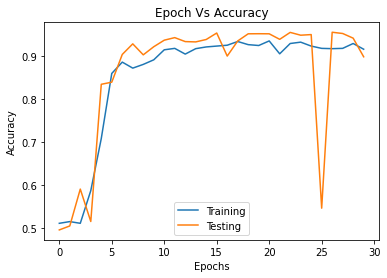

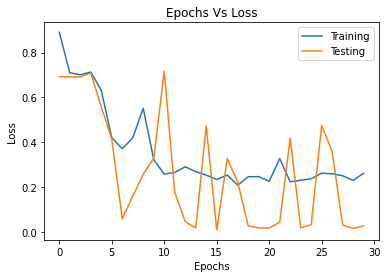

In [47]:

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['Training','Testing'],loc='best')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Epoch Vs Accuracy')
plt.show()


plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Training','Testing'],loc='best')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Epochs Vs Loss')
plt.show()

In [0]:
# Regularisation giving me the good accuracy and almost removed overfitting
# but i am not satisfied with this result so i would like to go for Transfer Learning

In [0]:
# I am taking VGG16 model ( having 16 hidden layers)


In [0]:
# resize the pixel in between 0 to 255
train_img_scaled=train_imgs/255.0
test_img_scaled=test_imgs/255.0

In [50]:
input_shape=(150,150,3)
vgg=VGG16(include_top=False,weights='imagenet',input_shape=input_shape)
output=vgg.layers[-1].output
output=keras.layers.Flatten()(output)
vgg_model=Model(vgg.input,output)

vgg_model.trainalble=False
for layer in vgg_model.layers[:5]:
  layer.trainable=False

def get_features(model,input_imgs):
  features=model.predict(input_imgs)
  return features

train_features=get_features(vgg_model,train_img_scaled)
test_features=get_features(vgg_model,test_img_scaled)


58892288/58889256 [==============================] - 6s 0us/step


In [51]:
vgg_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0   

In [61]:
from keras.layers import InputLayer
input_shape=vgg_model.output_shape[1]
model=Sequential()
model.add(InputLayer(input_shape=(input_shape,)))
model.add(Dense(512,activation='relu',input_dim=input_shape))
model.add(Dropout(0.4))
model.add(Dense(512,activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(1,activation='sigmoid'))

model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

model.summary()

history=model.fit(x=train_features,y=y_train,validation_data=(test_features,y_test),batch_size=30,epochs=30)



Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_16 (Dense)             (None, 512)               4194816   
_________________________________________________________________
dropout_9 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_17 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_10 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_18 (Dense)             (None, 1)                 513       
Total params: 4,457,985
Trainable params: 4,457,985
Non-trainable params: 0
_________________________________________________________________
Train on 22046 samples, validate on 5512 samples
Epoch 1/30
22046/22046 [==============================] - 7s 

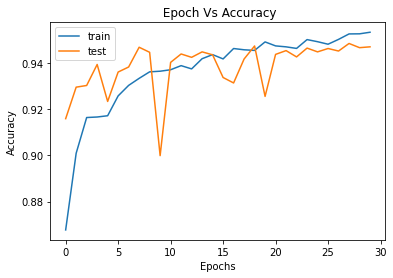

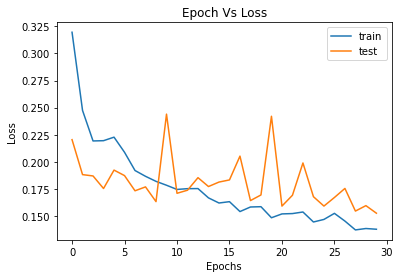

In [62]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['train','test'],loc='best')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title(' Epoch Vs Accuracy')
plt.show()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','test'],loc='best')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Epoch Vs Loss')
plt.show()

Pre-trained Model as a Feature Extractor

In [53]:
from keras.layers import InputLayer
input_shape=vgg_model.output_shape[1]
model=Sequential()
model.add(InputLayer(input_shape=(input_shape,)))
model.add(Dense(512,activation='relu',input_dim=input_shape))
model.add(Dropout(0.4))
model.add(Dense(512,activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(1,activation='sigmoid'))

model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

model.summary()

history=model.fit(x=train_features,y=y_train,validation_data=(test_features,y_test),
                  callbacks=[EarlyStopping(monitor='val_loss', patience=2),
             ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)],batch_size=30,epochs=30)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 512)               4194816   
_________________________________________________________________
dropout_5 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_6 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 513       
Total params: 4,457,985
Trainable params: 4,457,985
Non-trainable params: 0
_________________________________________________________________
Train on 22046 samples, validate on 5512 samples
Epoch 1/30
22046/22046 [==============================] - 7s 

In [0]:
# load model for Evaluation
from keras.models import load_model
saved_model = load_model('best_model.h5')
train_loss,train_acc = saved_model.evaluate(train_features, y_train, verbose=0)
test_loss,test_acc = saved_model.evaluate(test_features, y_test, verbose=0)


In [66]:
# accuracy
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

Train: 0.943, Test: 0.939


In [67]:
# loss
print('Train: %.3f, Test: %.3f' % (train_loss, test_loss))

Train: 0.169, Test: 0.178
